In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import openmc.mgxs as mgxs

import openmc
model = openmc.Model()


In [2]:
# Material definitions

# material 1 FUEL01
matuo2 = openmc.Material(name='uo2')
matuo2.add_nuclide('O16',  4.576420E-02)
matuo2.add_nuclide('U234',  6.118640E-06)
matuo2.add_nuclide('U235',  7.181320E-04)
matuo2.add_nuclide('U236',  3.298610E-06)
matuo2.add_nuclide('U238',  2.215460E-02)
matuo2.set_density('g/cm3', 10.25701)
matuo2.temperature=  600.000

# material 2 FUEL02
matgad = openmc.Material(name='gad')
matgad.add_nuclide('O16',  4.537050E-02)
matgad.add_nuclide('Gd152',  3.359600E-06)
matgad.add_nuclide('Gd154',  3.661900E-05)
matgad.add_nuclide('Gd155',  2.486060E-04)
matgad.add_nuclide('Gd156',  3.438490E-04)
matgad.add_nuclide('Gd157',  2.628840E-04)
matgad.add_nuclide('Gd158',  4.172550E-04)
matgad.add_nuclide('Gd160',  3.671980E-04)
matgad.add_nuclide('U234',  3.180960E-06)
matgad.add_nuclide('U235',  3.905000E-04)
matgad.add_nuclide('U236',  1.793000E-06)
matgad.add_nuclide('U238',  2.102990E-02)
matgad.set_density('g/cm3', 10.11099)
matgad.temperature=  600.000

#
matwater1 = openmc.Material(name='water1')
matwater1.add_nuclide('H1',  4.962240E-02)
matwater1.add_nuclide('O16',  2.481120E-02)
matwater1.add_nuclide('B10',  1.070700E-05)
matwater1.add_nuclide('B11',  4.309710E-05)
matwater1.set_density('g/cm3',  0.74300)
matwater1.temperature=  600.000
matwater1.add_s_alpha_beta('c_H_in_H2O')

#matwater2 = matwater1.clone()

#matwater3 = matwater2.clone()



model.materials = openmc.Materials([matuo2, matgad, matwater1])

In [3]:
# Create the surface used for each pin
rodlen = 0.26
x = 0
y = 0
bndw1 = openmc.XPlane( x0 = x-rodlen, surface_id = 101)
bnde1 = openmc.XPlane( x0 = x+rodlen, surface_id = 102)
bnds1 = openmc.YPlane( y0 = y-rodlen, surface_id = 103)
bndn1 = openmc.YPlane( y0 = y+rodlen, surface_id = 104)
regpin = +bndw1 & -bnde1 & +bnds1 & -bndn1
regcool = ~regpin

In [4]:
cells = {}
universes = {}
cells[matuo2.name] = openmc.Cell(name= 'uo2')
cells[matuo2.name].region = regpin
cells[matuo2.name].fill = matuo2


cells[matgad.name] = openmc.Cell(name= 'gad')
cells[matgad.name].region = regpin
cells[matgad.name].fill = matgad

cells['U-water'] = openmc.Cell(name= 'U-water')
cells['U-water'].region = regcool
cells['U-water'].fill = matwater1

cells['G-water'] = openmc.Cell(name= 'G-water')
cells['G-water'].region = regcool
cells['G-water'].fill = matwater1

outer_cell = openmc.Cell(name='outer')
outer_cell.fill = matwater1

outer_uni = openmc.Universe(name='outer')
outer_uni.add_cells([outer_cell])

universes[matuo2.name] = openmc.Universe(name = 'uo2') 
universes[matuo2.name].add_cells([cells['uo2'], cells['U-water']])


universes[matgad.name] = openmc.Universe(name = 'gad') 
universes[matgad.name].add_cells([cells[matgad.name], cells['G-water']])


In [5]:
lattice = openmc.RectLattice(name = '3x3-lat')
lattice.dimension = [3, 3]
lattice.lower_left = [-1.89, -1.89]
lattice.pitch = [1.26, 1.26]
lattice.outer = outer_uni
u = universes['uo2']
g = universes['gad']
lattice.universes = \
    [[u, u, u],
     [u, g, u],
     [u, u, u]]

In [6]:
# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-1.89, boundary_type='reflective')
max_x = openmc.XPlane(x0=+1.89, boundary_type='reflective')
min_y = openmc.YPlane(y0=-1.89, boundary_type='reflective')
max_y = openmc.YPlane(y0=+1.89, boundary_type='reflective')

root_cell = openmc.Cell(name='root cell')
root_cell.fill = lattice

root_cell.region = +min_x & -max_x & +min_y & -max_y

root_universe = openmc.Universe(name='root universe', universe_id=1000)
root_universe.add_cell(root_cell)

# Create Geometry and set root Universe
geometry = openmc.Geometry(root_universe)

# Export to "geometry.xml"
model.geometry = geometry
model.export_to_xml()

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

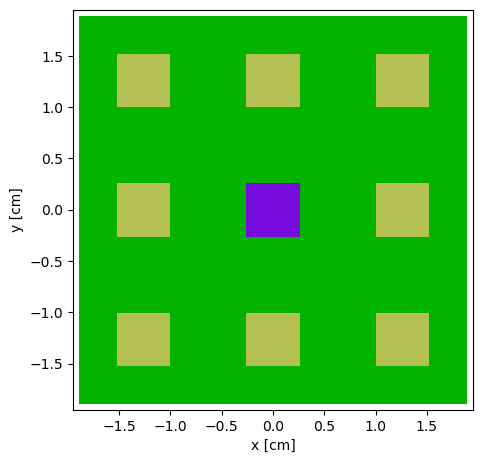

In [7]:
root_universe.plot(origin=(0, 0, 0.), width=(3.90, 3.90), pixels=(400, 400),
                   color_by='material')

In [8]:
#==================== Set up cross sections =======================

# Instantiate a "coarse" 2-group EnergyGroups object
coarse_groups = mgxs.EnergyGroups([0., 1.0, 20.0e6])

# Instantiate a "fine" 8-group EnergyGroups object
fine_groups = mgxs.EnergyGroups([0., 0.058, 0.14, 0.28,
                                 0.625, 4.0, 5.53e3, 821.0e3, 20.0e6])

# Initialize a 2-group MGXS Library for OpenMOC
mgxs_lib = openmc.mgxs.Library(model.geometry)
mgxs_lib.energy_groups = coarse_groups

# Types of cross sections available:
#   TotalXS ("total")
#   TransportXS ("transport" or "nu-transport with nu set to True)
#   AbsorptionXS ("absorption")
#   CaptureXS ("capture")
#   FissionXS ("fission" or "nu-fission" with nu set to True)
#   KappaFissionXS ("kappa-fission")
#   ScatterXS ("scatter" or "nu-scatter" with nu set to True)
#   ScatterMatrixXS ("scatter matrix" or "nu-scatter matrix" with nu set to True)
#   Chi ("chi")
#   ChiPrompt ("chi prompt")
#   InverseVelocity ("inverse-velocity")
#   PromptNuFissionXS ("prompt-nu-fission")
#   DelayedNuFissionXS ("delayed-nu-fission")
#   ChiDelayed ("chi-delayed")
#   Beta ("beta")

# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['transport', 'total', 'absorption', 'nu-fission', 'fission', 'scatter matrix', 'chi']

# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = 'material'

# Specify the cell domains over which to compute multi-group cross sections
# **** Note: users need to manually modify this list of cells they want edited
# **** Note: or call all cells
# mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.domains = model.geometry.get_all_materials().values()

for material in mgxs_lib.domains:
    print ("generate cross sections for material", material.id , material.name)

# Compute cross sections on a nuclide-by-nuclide basis  (not used here)
## mgxs_lib.by_nuclide = True

# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

# Create a "tallies.xml" file for the MGXS Library  - "merge" to reduce number of tallies
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies) # , merge=True)

generate cross sections for material 1 uo2
generate cross sections for material 3 water1
generate cross sections for material 2 gad


In [9]:
# Instantiate a tally Mesh
mesh = openmc.RegularMesh()
mesh.type = 'regular'
mesh.dimension = [100,100]
mesh.lower_left = [-1.90, -1.90]
mesh.upper_right = [+1.90, +1.90]

# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)
#create energy filter
energy_filter = openmc.EnergyFilter(coarse_groups.group_edges)

# Create mesh tally to score flux and fission rate
tally = openmc.Tally(name='flux')
tally.filters = [mesh_filter, energy_filter]
tally.scores = ['flux']
tallies.append(tally)

# Export all tallies to a "tallies.xml" file


model.tallies = tallies

In [10]:
# OpenMC simulation parameters
# Create an initial uniform spatial source distribution over fissionable zones
lower_left  = [   -1.89,  -1.89,-20]
upper_right = [   1.89,   1.89, 20]
uniform_dist = openmc.stats.Box(lower_left, upper_right)
settings = openmc.Settings()
settings.source = openmc.source.IndependentSource(space=uniform_dist, constraints={'fissionable': True})

In [12]:
settings.batches = 1000
settings.inactive = 100
settings.particles = 200000
settings.output = {'tallies': True}

model.settings = settings
#======================= Run ==========================

statepoint_file = model.run()
# ====================== Tallies ======================

# Load the last statepoint file
sp = openmc.StatePoint(statepoint_file)

# Retrieve OpenMC's k-effective value (used for edit at the end)
openmc_keff = sp.keff.nominal_value

# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

# Store the cross section data in an "mgxs/mgxs.h5" HDF5 binary file
print ("creating HDF cross section file")
mgxs_lib.build_hdf5_store(filename='mgxs.h5')   # , directory='mgxs')

# finished
print ("OpenMC keff ", openmc_keff)
print ("done")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
import matplotlib.pyplot as plt

# Load the statepoint file
sp = openmc.StatePoint(statepoint_file)

# Get the tally result
tally_result = sp.get_tally(name='flux')
tally_result.mean.shape=(mesh.dimension[0],mesh.dimension[1],energy_filter.num_bins)

# Replace 'your_statepoint_file.h5' with the actual path to your file.
# sp = openmc.StatePoint('your_statepoint_file.h5')
# tally_result = sp.get_tally(name='flux')



# --- Step 2: Automatically detect groups and create plots ---

# Get the number of energy groups from the shape of the tally data
num_groups = tally_result.mean.shape[2]

# Determine the grid size for the subplots (e.g., a 2x4 grid for 8 groups)
if num_groups <= 4:
    nrows = 1
    ncols = num_groups
else:
    ncols = 4
    nrows = int(np.ceil(num_groups / ncols))

# Create the figure and subplots with a suitable size
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))

# Flatten the 'axes' array to make it easy to loop through.
# This handles cases with more than one row of plots.
if num_groups > 1:
    axes = axes.flatten()
else:
    axes = [axes] # Handle the case of a single plot to avoid errors

# Loop through each energy group and create a plot
for i in range(num_groups):
    ax = axes[i]
    
    # Plot the data for the current group in reverse order, like your original code
    group_index_to_plot = num_groups-i-1
    
    # Use imshow to create the heatmap
    im = ax.imshow(tally_result.mean[:, :, group_index_to_plot])
    
    ax.set_title(f"Group {i}")
    
    # Add a colorbar to each subplot for scale
    fig.colorbar(im, ax=ax)

# Hide any unused subplots if the number of groups doesn't perfectly fill the grid
for i in range(num_groups, len(axes)):
    axes[i].axis('off')

# Adjust the layout to prevent titles from overlapping and display the plot
plt.tight_layout()
plt.savefig('combined_energy_groups_plot.png') # Saves the plot as an image
plt.show() # Displays the plot in a window

In [ ]:
print(model.geometry.get_all_materials().values())